# Number of mergers a galaxy undergoes across a redshift range

In [3]:
%matplotlib inline

In [4]:
# Import everything we need for this calculation
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad
import astropy.units as u
import matplotlib.pyplot as plt

# Set the cosmology we are using
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/home/ppxcjm/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Define the function which provides the average time between mergers. In Ownsworth et al. (2014), this is given by 

$$\Gamma(z) = \frac{\tau_m(z)}{f_m(z)}$$

The merger fraction (careful to note this is the *merger* fraction and not the *pair* fraction) is usually given by the form $f_m = f_0(1+z)^m$.

In [5]:
def Gamma_fn(z, tau_m, f0, m, C=0.6):

    # Average time between mergers = tau_m / f_m
    return tau_m / ((f0*(1+z)**m)*C)

The number of mergers a galaxy experiences, on average, is then the integral of $\Gamma(z)$ over time, as this represents the average time between merger events, as a function of redshift. This is written as

$$N_\text{merg} = \int_{t_1}^{t_2} \frac{dt}{\Gamma(z)}$$

but needs to be written in terms of redshift $z$ rather that time $t$. If we substitute $dt = -\frac{dz}{(1+z)H(z)}$ into this equation, where the minus comes from reversing the integration limits, we get

$$N_\text{merg} = -\int_{z_1}^{z_2} \frac{1}{(1+z)H(z)}\frac{dz}{\Gamma(z)}$$

This is equivalent to the formalism presented in Ownsworth et al. (2014) and Asa Bluck's papers as $H(z) = H_0E(z) = t_H^{-1}E(z)$.

Below, `int_fn()` encodes the expression to be integrated in the above equation.

In [6]:
def int_fn(z, tau_m, f0, m, C_merg=0.6):
    
    return -1. / (1+z) / cosmo.H(z) / Gamma_fn(z, tau_m, f0, m, C_merg)

Work out the number of mergers a galaxy undergoes across a redshift range, and the associated error on this value.

To do this, we generate N samples of the parameters from a normal distribution using their average values and associated errors.

Using 4910 / 5000 realizations...
N_merg = 1.25 (+1.28, -0.51)


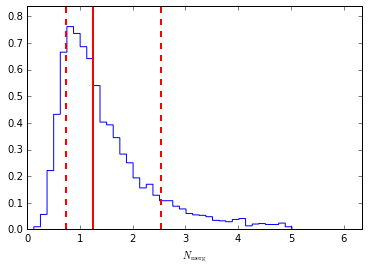

In [20]:
# =====================================
# Best-fit parameters and their errors
# =====================================
# Ownsworth et al. (2014)
tau_m, e_tau_m = 0.4*u.Gyr, 0.2*u.Gyr
f0, e_f0 = 0.009, 0.002
m, e_m = 2.9, 0.2
C_merg = 0.6

# # Mundy et al. (2016)
# tau_m, e_tau_m = 0.6*u.Gyr, 0.2*u.Gyr # Gyr
# f0, e_f0 = 0.025, 0.004
# m, e_m = 0.72, 0.20
# C_merg = 0.6

# Number of realizations
N = 5000

# Redshift bounds
z_min = 0.3
z_max = 3.0

# =====================================

taus = (e_tau_m * np.random.randn(N)) + tau_m
f0s = (e_f0 * np.random.randn(N)) + f0
ms = (e_m * np.random.randn(N)) + m

# Ensure things are physical
mask = np.logical_and(f0s > 0., taus > 0.)
taus, f0s, ms = taus[mask], f0s[mask], ms[mask]

N_merg = []

print 'Using {0} / {1} realizations...'.format(mask.sum(), N)

for i in range(mask.sum()):
    N_merg_i = quad(int_fn, z_max, z_min, args=(taus[i], 
                                f0s[i], ms[i], C_merg))[0]
    N_merg.append(N_merg_i)
    
N_av = np.nanpercentile(N_merg, 50.)
N_l = np.nanpercentile(N_merg, 15.6)
N_u = np.nanpercentile(N_merg, 84.4)

print 'N_merg = {0:1.2f} (+{1:1.2f}, -{2:1.2f})'.format(
            N_av, N_u-N_av, N_av-N_l)

# Plot the distribution
# =====================================
fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(N_merg, bins=np.arange(0, 
                            N_av + 3.*(N_u-N_av), N_av/10), 
                            normed=True, histtype='step')
# Set plot limits and labels
ax.plot([N_av, N_av], [0, n.max()*1.1], '-r', lw=2)
ax.plot([N_l, N_l], [0, n.max()*1.1], '--r', lw=2)
ax.plot([N_u, N_u], [0, n.max()*1.1], '--r', lw=2)
ax.set_ylim(0, n.max()*1.1)
ax.set_xlim(0, N_u*2.5)
ax.set_xlabel('$N_\mathrm{merg}$')
# =====================================

Resulting distribution of $N_\text{merg}$ identifies the upper and lower $1\sigma$ uncertainties on the obtained value.

It is worth noting that if the parameters are not foced into being physical (i.e. ensuring a postitive $f_0$), you recover the vlaue of $N_\text{merg} = 1.2$ quoted in Ownsworth et al. (2014). However, enforcing these conditions retrieves a larger value of $N_\text{merg} = 1.3$. What's more, the errors quoted in Ownsworth et al. (2014) are underestimated, with $N_\text{merg} = 1.3^{+1.3}_{-0.5}$ compared to the originally quoted $N_\text{merg} = 1.2 \pm 0.5$.